## Код нейросети для airline passengers

In [9]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# Функция для подготовки датасета
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [4]:
numpy.random.seed(7)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0078
Epoch 1/1
 - 0s - loss: 0.0052
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0048
Epoch 1/1
 - 0s - loss: 0.0047
Epoch 1/1
 - 0s - loss: 0.0046
Epoch 1/1
 - 0s - loss: 0.0045
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0044
Epoch 1/1
 - 0s - loss: 0.0043
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0042
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0041
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0040
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0039
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0038
Epoch 1/1
 - 0s - loss: 0.0037
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0036
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0035
Epoch 1/1
 - 0s - loss: 0.0034
Epoch 1/1
 - 0s - loss: 0.0033
Epoch 1/1
 - 0s - loss: 0.0033
Epoch 1/1
 - 0s - loss: 0.0032
Epoch 1/

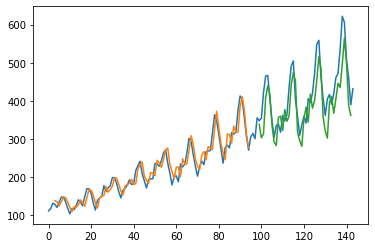

In [6]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()

trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Анализ

In [7]:
from sklearn.model_selection import ParameterGrid
from collections import namedtuple
import matplotlib.pyplot as plt
import time
import textwrap

In [102]:
def create_nn(trainX, trainY, rnn_type=('LSTM', 4), activation='tanh', dropout=0, batch_size=1, look_back=3, optimizer='adam', n_epochs=1, verbose=0):
    
    rnn_types = {
        'simpleRNN': SimpleRNN,
        'LSTM': LSTM,
        'GRU': GRU
    }
    
    model = Sequential()
    model.add(rnn_types[rnn_type[0]](units=rnn_type[1], activation=activation, 
                                  dropout=dropout,
                                  batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    for i in range(100):
        model.fit(trainX, trainY, epochs=n_epochs, batch_size=batch_size, verbose=verbose, shuffle=False)
        model.reset_states()
    
    return model

In [103]:
def evaluate_and_plot_results(train, test, params_list):

    for element in params_list:
        grid = ParameterGrid(element)
        rmse_list = []
        time_list = []
        for param in grid:
            if 'look_back' in element.keys():
                look_back = param['look_back']
                trainX, trainY = create_dataset(train, look_back)
                testX, testY = create_dataset(test, look_back)
                # reshape input to be [samples, time steps, features]
                trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
                testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
            else:
                look_back = 3
                trainX, trainY = create_dataset(train, look_back)
                testX, testY = create_dataset(test, look_back)
                # reshape input to be [samples, time steps, features]
                trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
                testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
            
            start = time.time()
            model = create_nn(trainX, trainY, **param)
            end = time.time()
            
            trainPredict = model.predict(trainX, batch_size=batch_size)
            model.reset_states()
            testPredict = model.predict(testX, batch_size=batch_size)
            

            trainPredict = scaler.inverse_transform(trainPredict)
            trainY = scaler.inverse_transform([trainY])
            testPredict = scaler.inverse_transform(testPredict)
            testY = scaler.inverse_transform([testY])
            
            rmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
            rmse_list.append(rmse)
            time_list.append(end - start)
            
            
            trainPredictPlot = numpy.empty_like(dataset)
            trainPredictPlot[:, :] = numpy.nan
            trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

            testPredictPlot = numpy.empty_like(dataset)
            testPredictPlot[:, :] = numpy.nan
            testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
            
            trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
            print('Train Score: %.2f RMSE' % (trainScore))
            testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
            print('Test Score: %.2f RMSE' % (testScore))
            
            plt.figure(figsize=(3,2))
            plt.title(param)
            plt.plot(scaler.inverse_transform(dataset))
            plt.plot(trainPredictPlot)
            plt.plot(testPredictPlot)
            plt.show()
            print('_'*50)
        
        to_print_rmse = [float('{:.3f}'.format(x)) for x in rmse_list]
        to_print_time = [float('{:.3f}'.format(x)) for x in time_list]
        fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 14))
        labels = [str(ele) for ele in list(element.values())[0]]
        len_labels = len(labels)
        labels = [textwrap.fill(text,25) for text in labels]
        ax1.barh(labels, rmse_list, color='cornflowerblue')
        ax2.barh(labels, time_list, color='cornflowerblue')
        
        for i, v in enumerate(rmse_list):
            if v == min(rmse_list):
                ax1.text(v-v/2, 
                         i-len(rmse_list)/80, 
                         to_print_rmse[i], 
                         color='green', 
                         fontweight='bold', 
                         fontsize=18)
            elif v == max(rmse_list):
                ax1.text(v-v/2, 
                         i-len(rmse_list)/80, 
                         to_print_rmse[i], 
                         color='red', 
                         fontweight='bold', 
                         fontsize=18)
            else:
                ax1.text(v-v/2, 
                         i-len(rmse_list)/80, 
                         to_print_rmse[i], 
                         color='black', 
                         fontweight='bold', 
                         fontsize=18)
        for i, v in enumerate(time_list):
            if v == max(time_list):
                ax2.text(v/2, i-len(time_list)/80, to_print_time[i], color='red', fontweight='bold', fontsize=18)
            elif v == min(time_list):
                ax2.text(v/2, i-len(time_list)/80, to_print_time[i], color='green', fontweight='bold', fontsize=18)
            else:
                ax2.text(v/2, i-len(time_list)/80, to_print_time[i], color='black', fontweight='bold', fontsize=18)

        ax1.set_xlabel('Точность')
        ax2.set_xlabel('Время обучения')
        ax1.grid(True)
        ax2.grid(True)
        plt.yticks(range(len_labels), labels)
        plt.show()
        print('_' * 100)

In [104]:
params_list = [{'rnn_type': [('simpleRNN', 2), ('simpleRNN', 4), ('simpleRNN', 8),
                            ('LSTM', 2), ('LSTM', 4), ('LSTM', 8),
                            ('GRU', 2), ('GRU', 4), ('GRU', 8)]},
               {'activation': ['tanh', 'relu', 'elu', 'selu', 'sigmoid', 'softmax']},
               {'optimizer': ['adam', 'adamax', 'nadam', 'sgd']},
               {'look_back': [3, 4, 5, 10]},
               {'dropout': [0, 0.1, 0.2, 0.25]},
               {'n_epochs': [1, 2, 3, 5, 10]}]

Train Score: 21.53 RMSE
Test Score: 52.89 RMSE


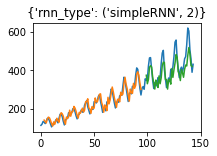

__________________________________________________
Train Score: 25.27 RMSE
Test Score: 57.68 RMSE


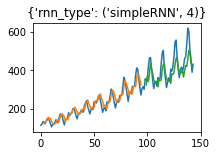

__________________________________________________
Train Score: 18.67 RMSE
Test Score: 57.62 RMSE


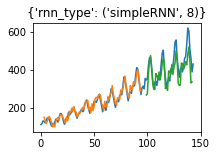

__________________________________________________
Train Score: 27.42 RMSE
Test Score: 76.40 RMSE


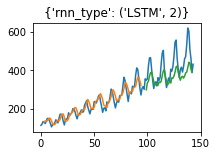

__________________________________________________
Train Score: 24.72 RMSE
Test Score: 54.50 RMSE


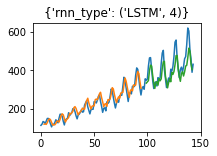

__________________________________________________
Train Score: 19.03 RMSE
Test Score: 64.55 RMSE


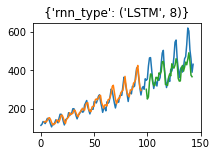

__________________________________________________
Train Score: 24.57 RMSE
Test Score: 51.53 RMSE


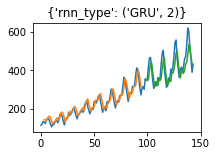

__________________________________________________
Train Score: 24.56 RMSE
Test Score: 48.42 RMSE


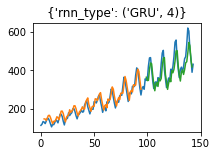

__________________________________________________
Train Score: 22.63 RMSE
Test Score: 45.28 RMSE


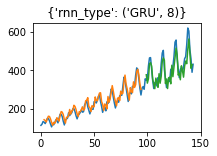

__________________________________________________


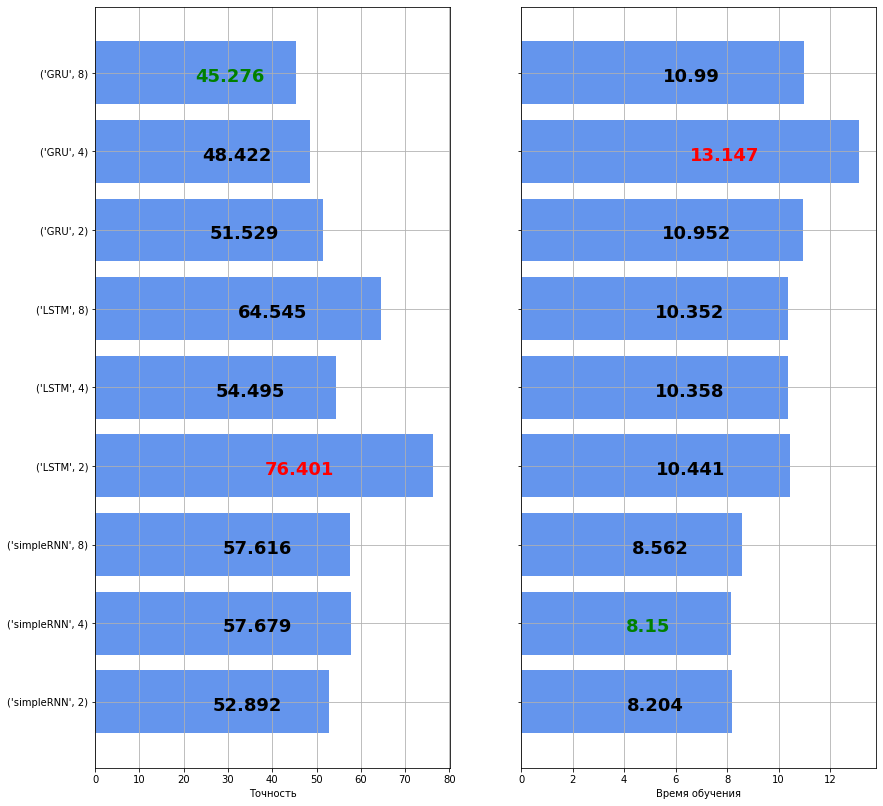

____________________________________________________________________________________________________
Train Score: 19.74 RMSE
Test Score: 68.17 RMSE


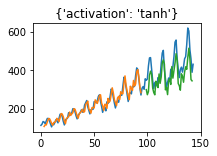

__________________________________________________
Train Score: 22.65 RMSE
Test Score: 107.57 RMSE


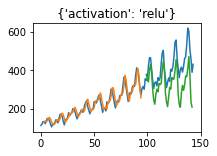

__________________________________________________
Train Score: 27.44 RMSE
Test Score: 52.62 RMSE


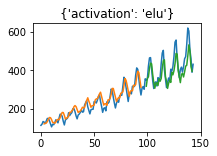

__________________________________________________
Train Score: 116.36 RMSE
Test Score: 98.62 RMSE


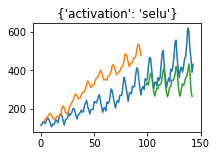

__________________________________________________
Train Score: 26.96 RMSE
Test Score: 57.38 RMSE


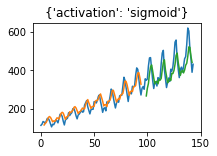

__________________________________________________
Train Score: 28.63 RMSE
Test Score: 88.51 RMSE


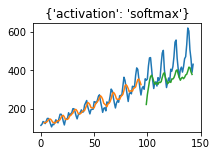

__________________________________________________


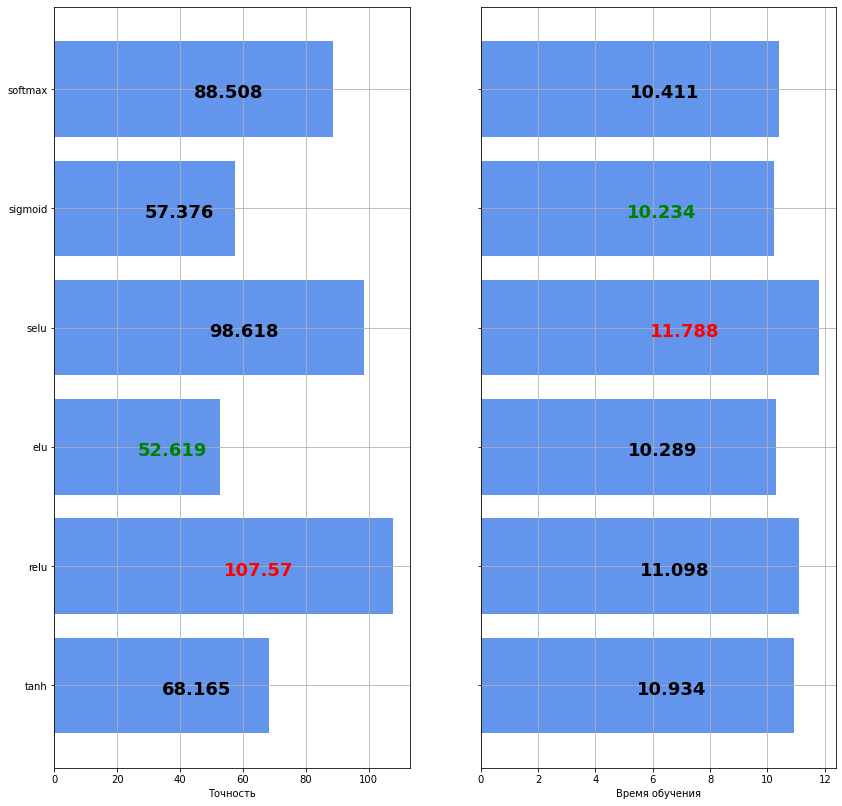

____________________________________________________________________________________________________
Train Score: 21.23 RMSE
Test Score: 57.69 RMSE


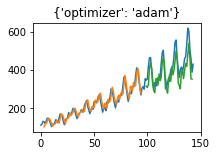

__________________________________________________
Train Score: 24.59 RMSE
Test Score: 65.02 RMSE


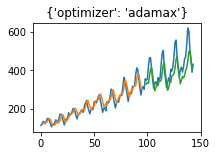

__________________________________________________
Train Score: 69.78 RMSE
Test Score: 211.25 RMSE


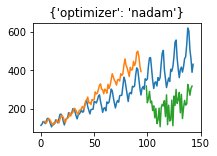

__________________________________________________
Train Score: 31.43 RMSE
Test Score: 83.46 RMSE


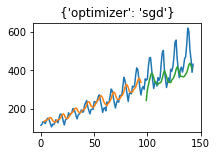

__________________________________________________


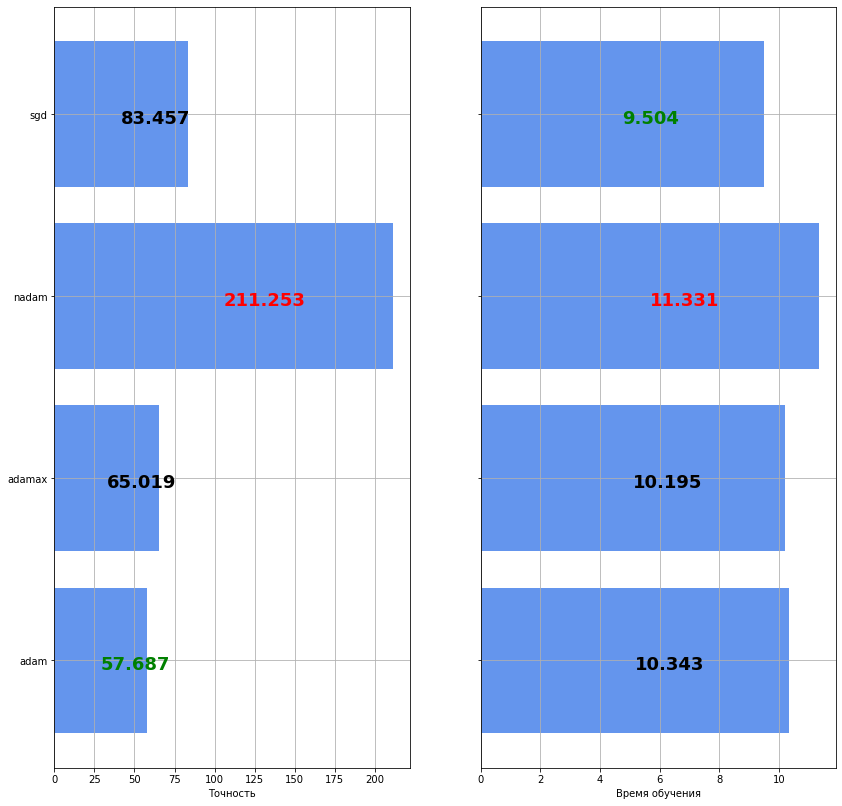

____________________________________________________________________________________________________
Train Score: 23.27 RMSE
Test Score: 62.69 RMSE


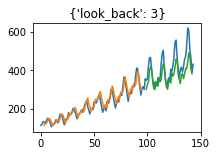

__________________________________________________
Train Score: 28.00 RMSE
Test Score: 63.72 RMSE


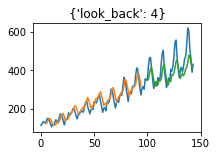

__________________________________________________
Train Score: 27.53 RMSE
Test Score: 54.86 RMSE


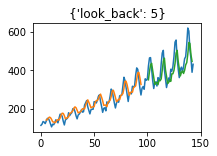

__________________________________________________
Train Score: 32.00 RMSE
Test Score: 88.59 RMSE


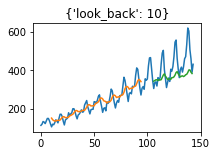

__________________________________________________


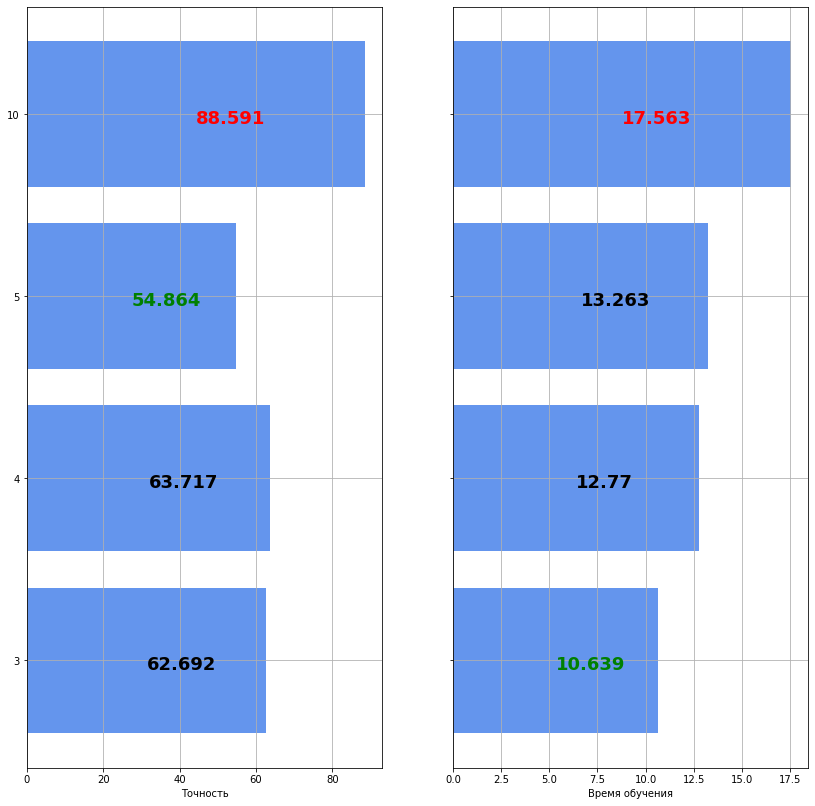

____________________________________________________________________________________________________
Train Score: 22.31 RMSE
Test Score: 61.59 RMSE


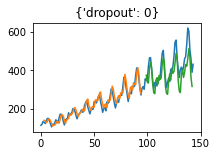

__________________________________________________
Train Score: 32.86 RMSE
Test Score: 85.58 RMSE


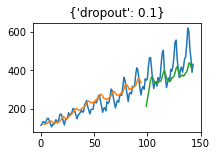

__________________________________________________
Train Score: 27.73 RMSE
Test Score: 83.12 RMSE


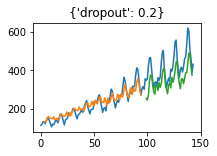

__________________________________________________
Train Score: 30.37 RMSE
Test Score: 98.53 RMSE


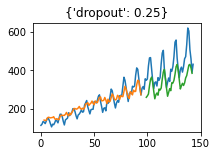

__________________________________________________


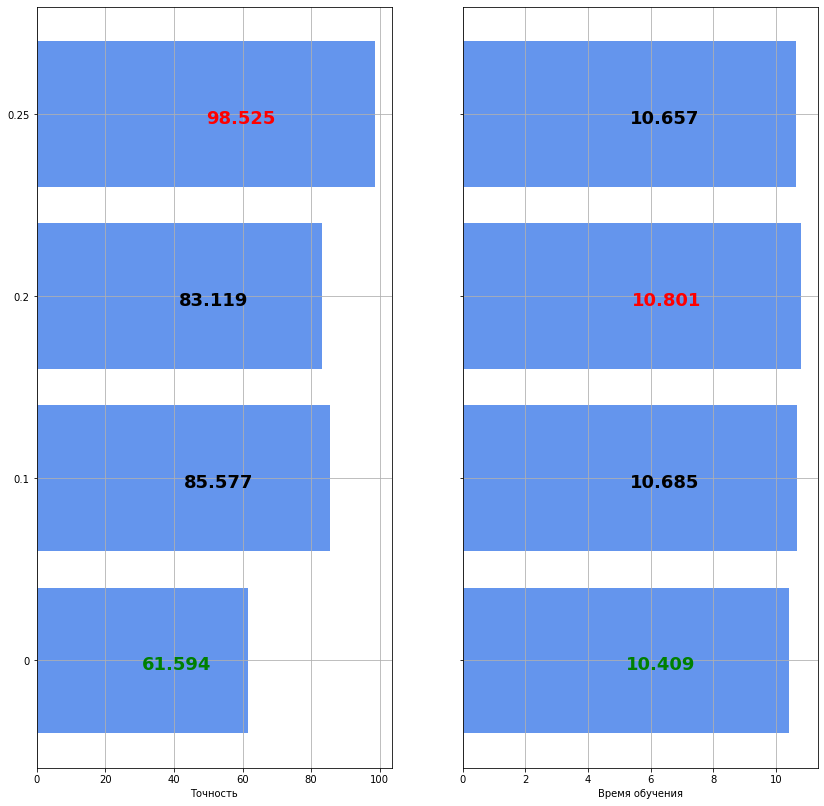

____________________________________________________________________________________________________
Train Score: 23.99 RMSE
Test Score: 68.22 RMSE


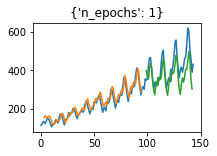

__________________________________________________
Train Score: 20.93 RMSE
Test Score: 58.84 RMSE


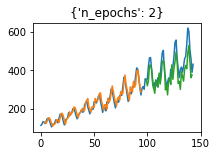

__________________________________________________
Train Score: 21.67 RMSE
Test Score: 47.62 RMSE


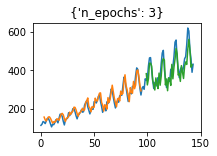

__________________________________________________
Train Score: 19.68 RMSE
Test Score: 64.82 RMSE


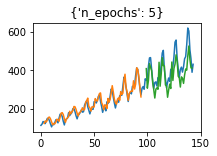

__________________________________________________
Train Score: 20.64 RMSE
Test Score: 87.01 RMSE


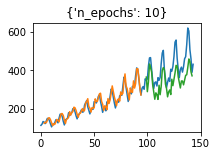

__________________________________________________


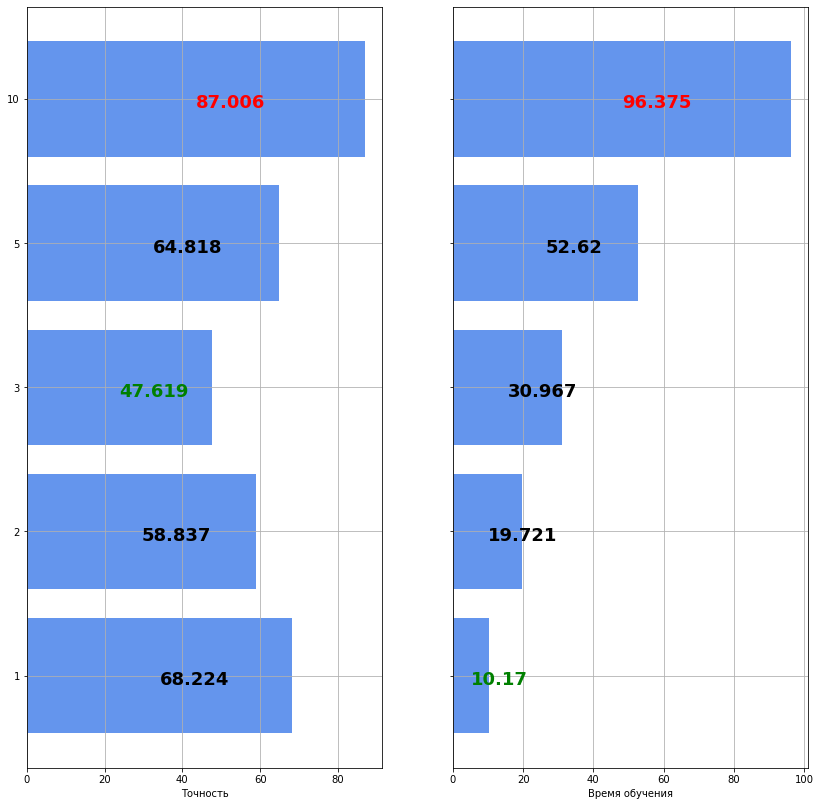

____________________________________________________________________________________________________


In [105]:
evaluate_and_plot_results(train, test, params_list)

### Выводы

* Среди различных видов нейросетей для данной задачи лучше всего себя показала сеть на основе GRU с количеством юнитов равным 8
* Увеличение количества юнитов для GRU показывает стабильное улучшение качества предсказания. Это утверждение не подтверждается для других типов нейросетей
* GRU для всех трех конфигурации показала точность выше остальных нейросетей. Думаю проблема свяазана с малым количеством эпох обучения. По стандарту сети обучались в течение одной эпохи
* Лучший тип активации для данной задачи - elu
* Лучший оптимайзер - adam
* При изменении параметра look_back лучшим оказался парметр равный 5. Думаю, это связано с особенностью данных: количество пассажиров представлено за месяц. Значит, с параметром 5 мы почти попадаем в полугодовую сезонность. Возможно, 6 будет давать даже более точные результаты
* dropout ухудшает качество модели. Данных и связей и так достаточно немного, думаю, поэтому обрезание плохо сказывается на точности
* Лучший результат в зависимости от количества эпох обучения - 3. Вероятно, дальше сеть начинает переобучаться. Это видно по увеличивающемуся разрыву между предсказаниями на тренировочной и тестовой выборках